# Imports

In [911]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [806]:
df = pd.read_csv("datasets/df_players_merged.csv")

In [807]:
df.head()

,Unnamed: 0,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,...,%PF,%PFD,%PTS,PDV,Taille,Poids,Exp,Pays,iso_alpha,country
0,0,Kevin Durant,BKN,33,20,14,6,35.8,28.6,10.4,...,10.0,31.8,33.8,F,2.08,108.9,13.0,États-Unis,USA,United States
1,1,Stephen Curry,GSW,33,20,17,3,34.3,27.8,9.2,...,12.8,25.5,32.8,G,1.88,83.9,12.0,États-Unis,USA,United States
2,2,Giannis Antetokounmpo,MIL,26,21,14,7,32.7,27.6,9.8,...,24.3,60.0,34.9,F,2.11,109.8,8.0,Grèce,GRC,Greece
3,3,Trae Young,ATL,23,22,12,10,33.9,26.3,9.3,...,13.6,36.8,32.3,G,1.85,74.4,3.0,États-Unis,USA,United States
4,4,DeMar DeRozan,CHI,32,23,15,8,35.1,26.3,9.3,...,16.0,43.2,31.9,F,1.98,99.8,12.0,États-Unis,USA,United States


In [808]:
df.shape

(460, 85)

# Exploratory Data Analysis

### Visualize the target

We want to predict the role of a player, let's see which column corresponds to this information

In [809]:
df.columns

Index(['Unnamed: 0', 'PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3',
       '+/-', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST RATIO',
       'OREB%', 'DREB%', 'REB%', 'TO RATIO', 'EFG%', 'TS%', 'USG%', 'PACE',
       'PIE', 'POSS', '%FGA\n2PT', '%FGA\n3PT', '%PTS\n2PT', '%PTS\n2PT MR',
       '%PTS\n3PT', '%PTS\nFBPS', '%PTS\nFT', '%PTS\nOFFTO', '%PTS\nPITP',
       '2FGM\n%AST', '2FGM\n%UAST', '3FGM\n%AST', '3FGM\n%UAST', 'FGM\n%AST',
       'FGM\n%UAST', '%FGM', '%FGA', '%3PM', '%3PA', '%FTM', '%FTA', '%OREB',
       '%DREB', '%REB', '%AST', '%TOV', '%STL', '%BLK', '%BLKA', '%PF', '%PFD',
       '%PTS', 'PDV', 'Taille', 'Poids', 'Exp', 'Pays', 'iso_alpha',
       'country'],
      dtype='object')

After some researchs, we find out that the position of a player is in the column "PDV"

In [810]:
y = df["PDV"]

<BarContainer object of 3 artists>

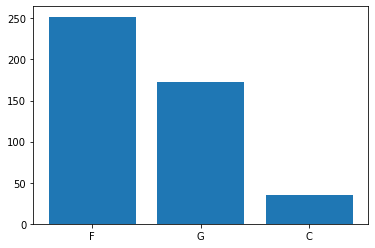

In [811]:
plt.bar(y.unique(),y.value_counts())


There is 3 types of players : F, G and C.
F = forward
G = guard
C = center


The dataset is very unbalanced, there are almost no Centers compared to the other positions.

### Select the features

Thanks to the different graphs we have done before (see the PDF and the dashboard in the section Role Analysis), we can select some interesting features to predict the position of a player

At this point,we think that we will to predict the role of a player using his height, his weight, and the numbers of 2 points and 3 points shots attempted

In [812]:
X = df[["Taille","Poids","FGA","3PA"]]

In [813]:
X.dtypes

Taille    float64
Poids     float64
FGA       float64
3PA       float64
dtype: object

<AxesSubplot:>

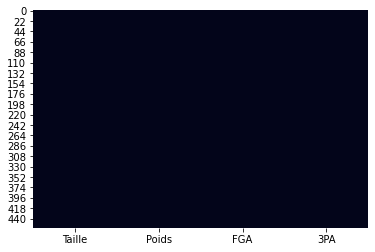

In [814]:
sns.heatmap(X.isna(), cbar=False)

We can see that there isn't any missing value in our dataset

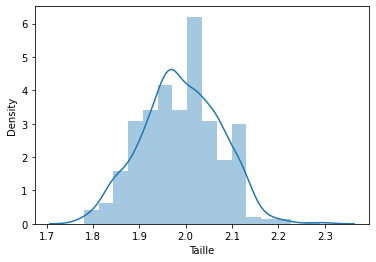

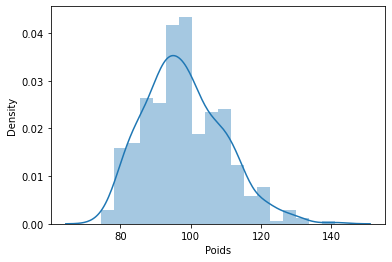

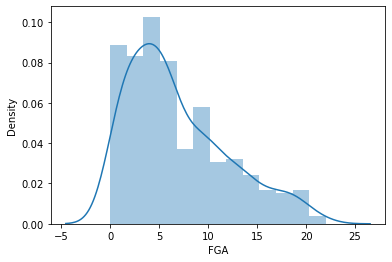

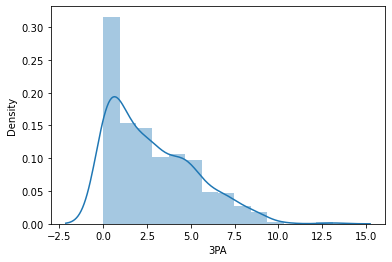

In [815]:
for col in X.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

Our features are not normalized so we wil have to do it in the preprocessing part for a better precision of our model

In [816]:
(X["3PA"][X["3PA"]==0].shape[0]/X["3PA"].shape[0])*100

10.434782608695652

10% of the players' 3 points attempts are null

In [817]:
(X["FGA"][X["FGA"]==0].shape[0]/X["FGA"].shape[0])*100

2.391304347826087

2% of the players' field goal attempts are null

# Preprocessing

We will encode the target variable TDV in order to manipulate it more easily


In [818]:
df["PDV"] = df["PDV"].replace({"F":1,"G":2,"C":3})

Now we will balance our dataset in order to visualize the correlation between the features and the target, it means we will select the same amount of Forwards, Guards and Centers.

In [819]:
df_role1 = df[df["PDV"]==1][:50]
df_role2 = df[df["PDV"]==2][:50]
df_role3 = df[df["PDV"]==3][:50]
df_balanced = pd.concat([df_role1,df_role2,df_role3])

In [820]:
abs(df_balanced.corr(method="spearman")["PDV"][abs(df_balanced.corr(method="spearman")["PDV"])>0.2])

Unnamed: 0      0.509597
GP              0.267021
MIN             0.465130
PTS             0.510056
FGM             0.471490
FGA             0.485685
FG%             0.220417
3PM             0.398845
3PA             0.410906
3P%             0.211635
FTM             0.476297
FTA             0.451067
FT%             0.295784
DREB            0.289959
REB             0.202649
AST             0.275462
TOV             0.303060
STL             0.251763
FP              0.369772
OREB%           0.335032
REB%            0.210038
TO RATIO        0.325619
USG%            0.392042
%FGA\n2PT       0.291819
%FGA\n3PT       0.291819
%PTS\n2PT       0.291756
%PTS\n2PT MR    0.399587
%PTS\n3PT       0.310943
%PTS\nFBPS      0.421408
%PTS\nPITP      0.345430
2FGM\n%AST      0.210610
2FGM\n%UAST     0.245691
3FGM\n%AST      0.204518
3FGM\n%UAST     0.291440
%FGM            0.352027
%FGA            0.408718
%3PM            0.372412
%3PA            0.394537
%OREB           0.309218
%BLK            0.273206


We can see that the position of a player is quite correlated with the Assists(AST), the Defensive Rebounds(DREB) ,OffensiveRebounds(REB), the Free Throws Made (FTM), the Minutes(MIN),  the Turn Overs(TOV) and the  so we could add theses stats to our dataset to increase the precision (we add the Offensive Rebounds to be in the same idea of the Defensive Rebounds)
We won't take others stats because they are high correlated between them (for example Field Goal Attempted and Field Goal Made)
We take the Turn Overs stats instead of Minutes because maybe if a player get injuried it could biased our model

In [821]:
df = df[["TOV","Poids","Taille","%AST","%DREB","%OREB","FGA","3PA","PDV"]]

In [822]:
df.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'))

,TOV,Poids,Taille,%AST,%DREB,%OREB,FGA,3PA,PDV
TOV,1.0,-0.0054,-0.054,0.47,0.13,0.039,0.83,0.58,0.096
Poids,-0.0054,1.0,0.75,-0.28,0.51,0.54,-0.03,-0.25,-0.31
Taille,-0.054,0.75,1.0,-0.38,0.58,0.58,-0.069,-0.28,-0.39
%AST,0.47,-0.28,-0.38,1.0,-0.068,-0.13,0.35,0.28,0.21
%DREB,0.13,0.51,0.58,-0.068,1.0,0.48,0.048,-0.2,-0.23
%OREB,0.039,0.54,0.58,-0.13,0.48,1.0,-0.053,-0.33,-0.18
FGA,0.83,-0.03,-0.069,0.35,0.048,-0.053,1.0,0.81,0.03
3PA,0.58,-0.25,-0.28,0.28,-0.2,-0.33,0.81,1.0,0.0045
PDV,0.096,-0.31,-0.39,0.21,-0.23,-0.18,0.03,0.0045,1.0


In [823]:
df.head()

,TOV,Poids,Taille,%AST,%DREB,%OREB,FGA,3PA,PDV
0,3.0,108.9,2.08,27.7,25.5,8.7,19.2,4.8,1
1,3.2,83.9,1.88,29.6,19.5,7.1,20.3,13.1,2
2,3.2,109.8,2.11,35.6,36.0,31.0,18.4,4.1,1
3,3.8,74.4,1.85,52.8,13.1,8.3,19.9,6.9,2
4,2.0,99.8,1.98,25.1,17.8,10.1,18.8,2.5,1


In [824]:
df.shape

(460, 9)

Thanks to the EDA and the preprocessing part, we kept 8 interesting features to predict to position of a player

Let's create our train and test sets

In [825]:
trainset, testset = train_test_split(df,test_size=0.33,random_state=28)

In [826]:
trainset.shape

(308, 9)

In [827]:
testset.shape

(152, 9)

In [828]:
y_train = trainset["PDV"]
X_train = trainset.drop("PDV",axis=1)
y_test = testset["PDV"]
X_test = testset.drop("PDV",axis=1)

In [829]:
y_test.value_counts()

1    88
2    56
3     8
Name: PDV, dtype: int64

In [830]:
y_train.value_counts()

1    164
2    117
3     27
Name: PDV, dtype: int64

The dataset is unbalanced but if we balanced it by taking the same amount of player for each position, we will lose a lot of training datas. So, we will try to train our model like that

# Evaluation Function

Let's code a function to evaluate easily the performance of our model
We choose to use the accuracy metric, which means that we want to have as much correct answers as possible, which is the best choice for a multiclass problem like that.

In [831]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=2, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    

# Create the model

In [832]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=8))

In [993]:
KNN = make_pipeline(preprocessor,StandardScaler(), KNeighborsClassifier())
RandomForest = make_pipeline(preprocessor,StandardScaler(), RandomForestClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
LogisticReg = make_pipeline(preprocessor,StandardScaler(), LogisticRegression(random_state=0))

In [994]:
dict_of_models = {'RandomForest': RandomForest,
                  'SVM': SVM,
                  'KNN': KNN,
                  'LogisticReg':LogisticReg
                 }

RandomForest
[[76  7  5]
 [ 5 51  0]
 [ 2  0  6]]
              precision    recall  f1-score   support

           1       0.92      0.86      0.89        88
           2       0.88      0.91      0.89        56
           3       0.55      0.75      0.63         8

    accuracy                           0.88       152
   macro avg       0.78      0.84      0.81       152
weighted avg       0.88      0.88      0.88       152

0.875
SVM
[[81  5  2]
 [ 7 49  0]
 [ 5  0  3]]
              precision    recall  f1-score   support

           1       0.87      0.92      0.90        88
           2       0.91      0.88      0.89        56
           3       0.60      0.38      0.46         8

    accuracy                           0.88       152
   macro avg       0.79      0.72      0.75       152
weighted avg       0.87      0.88      0.87       152

0.875
KNN
[[73  7  8]
 [ 6 50  0]
 [ 3  0  5]]
              precision    recall  f1-score   support

           1       0.89      0.83      

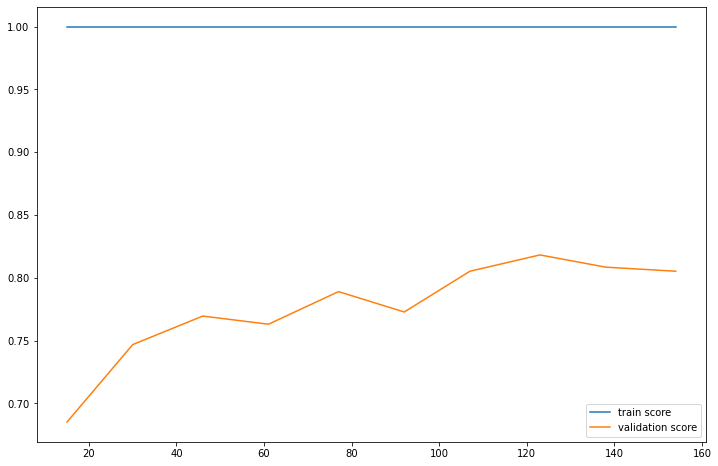

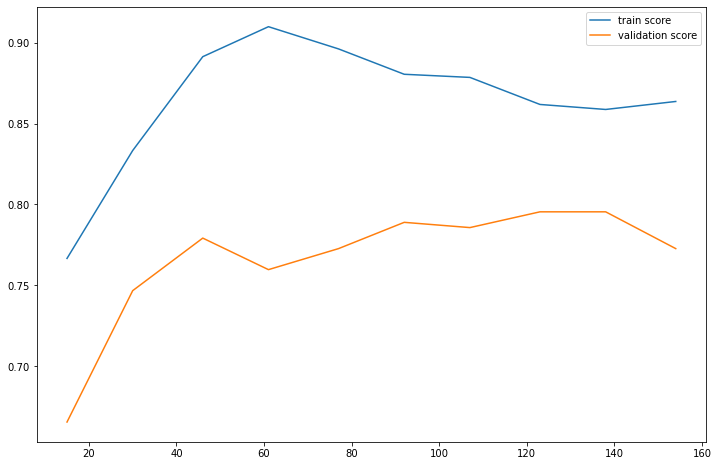

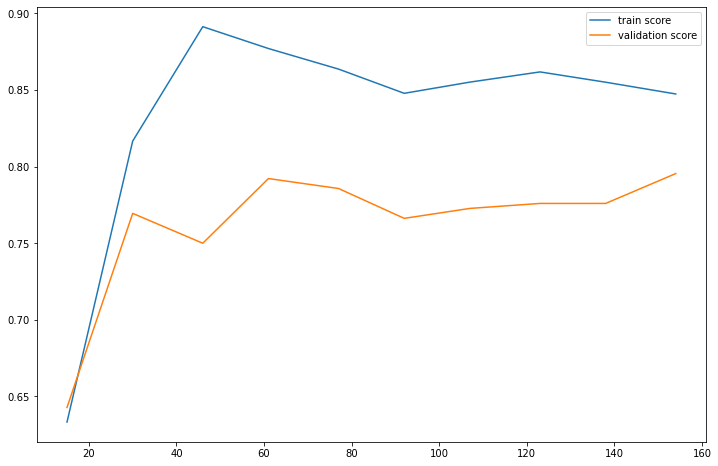

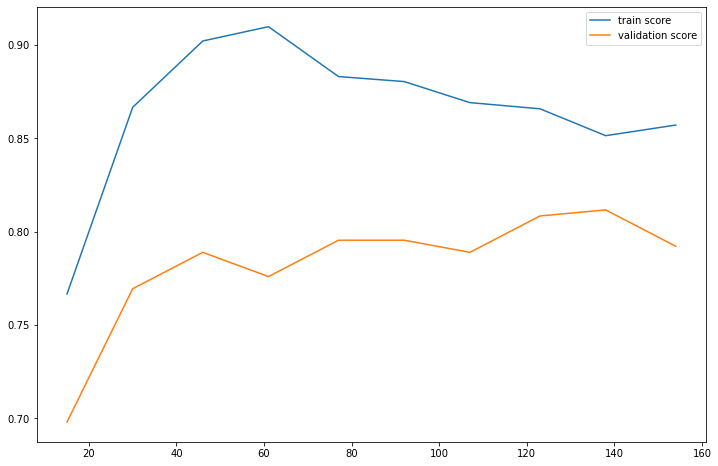

In [995]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)
    print(model.score(X_test,y_test))

We will try to optimise the performance of the RandomForest model, because if we manage to reduce the overfitting we could reach a really high score.
We will optimize the LogisticRegression too, as the curves seems to be promising (no overfitting compared to the RandomForest model).

# Optimization

In [836]:
trainset["PDV"].value_counts()

1    164
2    117
3     27
Name: PDV, dtype: int64

### Let's optimize the RandomForest model

In [792]:
RandomForest.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'standardscaler', 'randomforestclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__polynomialfeatures', 'pipeline__selectkbest', 'pipeline__polynomialfeatures__degree', 'pipeline__polynomialfeatures__include_bias', 'pipeline__polynomialfeatures__interaction_only', 'pipeline__polynomialfeatures__order', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples_leaf', 'randomforestclas

In [996]:
hyper_params = {'randomforestclassifier__criterion':["gini","entropy"],
               'pipeline__polynomialfeatures__degree':[1,2,3,4],
                'randomforestclassifier__n_estimators':range(40,70),
                'randomforestclassifier__random_state':range(10),
                
               }

In [997]:
grid = RandomizedSearchCV(RandomForest, hyper_params, scoring='accuracy', cv=2,
                          n_iter=100)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'randomforestclassifier__random_state': 9}
              precision    recall  f1-score   support

           1       0.93      0.91      0.92        88
           2       0.93      0.91      0.92        56
           3       0.64      0.88      0.74         8

    accuracy                           0.91       152
   macro avg       0.83      0.90      0.86       152
weighted avg       0.91      0.91      0.91       152

[[80  4  4]
 [ 5 51  0]
 [ 1  0  7]]


We had an accuracy of 88% before tuning the hyperparameters, and now we have an accuracy of 91%, which is a good increase because it's hard to increase the precision of a model when the precision is already high like here.

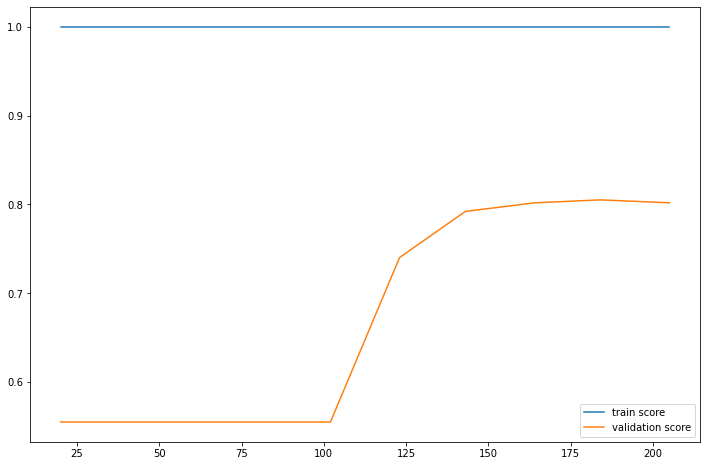

In [443]:
N, train_score, val_score = learning_curve(grid, X_train, y_train,
                                              cv=3, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

We can see with the train/validation curves that are our model is overfitting.
But we can see that the training curve starts to decrease, and the validation curve keeps increasing, so with more datas we could increase even more the score.

### Let's optimize the LogisticRegression model

In [731]:
LogisticReg.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'standardscaler', 'logisticregression', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__polynomialfeatures', 'pipeline__selectkbest', 'pipeline__polynomialfeatures__degree', 'pipeline__polynomialfeatures__include_bias', 'pipeline__polynomialfeatures__interaction_only', 'pipeline__polynomialfeatures__order', 'pipeline__selectkbest__k', 'pipeline__selectkbest__score_func', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregressio

In [932]:
hyper_params = {
               'pipeline__polynomialfeatures__degree':[1,2,3,4,5,6,7,8],
                'logisticregression__penalty':['l2',"l1","elasticnet","none"],
                'logisticregression__C':range(1,50),
                'logisticregression__tol':[0.0001,0.001,0.01,0.1],
                'logisticregression__solver':["newton_cg","sag","saga","liblinear"]
               }

In [933]:
grid = RandomizedSearchCV(LogisticReg, hyper_params, scoring='accuracy', cv=2,
                          n_iter=100)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

{'pipeline__polynomialfeatures__degree': 6, 'logisticregression__tol': 0.01, 'logisticregression__solver': 'sag', 'logisticregression__penalty': 'l2', 'logisticregression__C': 15}
              precision    recall  f1-score   support

           1       0.90      0.90      0.90        88
           2       0.91      0.91      0.91        56
           3       0.50      0.50      0.50         8

    accuracy                           0.88       152
   macro avg       0.77      0.77      0.77       152
weighted avg       0.88      0.88      0.88       152

[[79  5  4]
 [ 5 51  0]
 [ 4  0  4]]


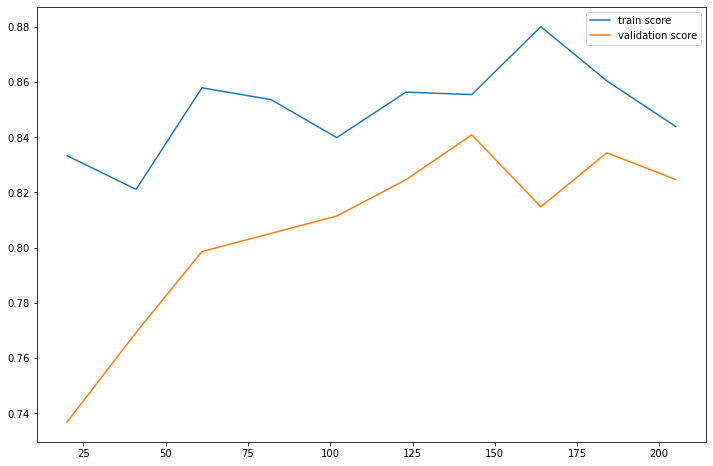

In [936]:
N, train_score, val_score = learning_curve(grid, X_train, y_train,
                                              cv=3, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

The results are interesting but are not better than the first model, the RandomForest, so will keep the first one.

### Best model

Finally we saved one of the RandomForest model we managed to optimize with the RandomizedSearchCV, who gives a 95% accuracy which is really high

In [999]:
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.90      0.95        88
           2       0.89      1.00      0.94        56
           3       0.80      1.00      0.89         8

    accuracy                           0.94       152
   macro avg       0.90      0.97      0.93       152
weighted avg       0.95      0.94      0.94       152

[[79  7  2]
 [ 0 56  0]
 [ 0  0  8]]


We can see that this model is very precise, he did no error on the predictions of the position Forwards and Centers.

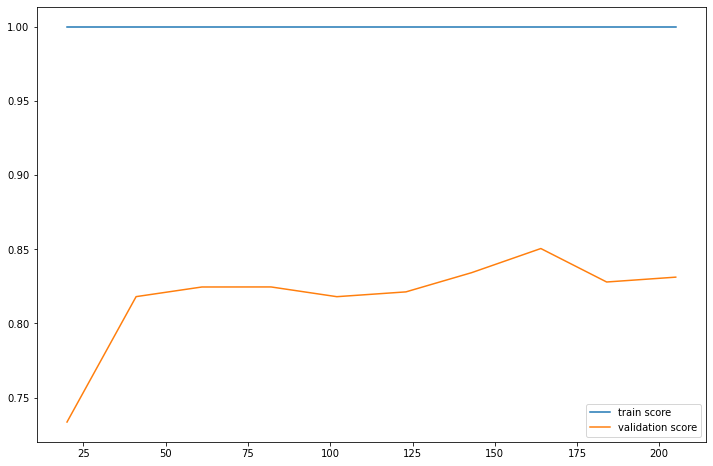

In [937]:
N, train_score, val_score = learning_curve(best_model, X_train, y_train,
                                              cv=3, scoring='accuracy',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

# Conclusion

Finally we managed to reach a really good accuracy of 94%. We could probably increase this score even more if we had more datas especially for the "Centers". We can see that the model is overfitting so with more datas we would have been able to solve this problem.